# HEIG-Vd - Apprentissage supervisé (APV)

## Travail Pratique 02 - Régression logistique

<div class="alert alert-block alert-success">
<b>Informations générales </b>
</div>

**Professeur**: Stephan Robert

**Assistant(s)**: Félicien Hêche

**Contact**: stephan.o.robert@gmail.com, felicien.heche@gmail.com ou via Teams

**Rendu**: 

- Date: 18 ocrobre 2023 
- Modalité: Travail individuel. Une fois complétées, copiez les réponses dans le ficher "**TP2_APV_S1-2023_Nom_Prenom.*****" (*** = ce que vous voulez qui soit lisible pour nous: .pdf, .html, ...) en remplaçant Nom et Prenom par les votres puis uploader votre fichier sur Cyberlearn.
- Note: Ce TP est noté sur 6.

**Étudiant**:

- Prénom Nom

<div class="alert alert-block alert-success">

<b>But du TP </b>
</div>

Le but de ce deuxième TP est d'étudier la régression logistique à une seule variable. 


<!---
<div class="alert alert-block alert-info">
<b>Rappel </b>
</div>
-->

<div class="alert alert-block alert-success">
<b>Table des matières </b>
</div>

1. Régression logistique
>* Visualisation des données
>* Implémentation
>* Loss function et gradient
>* Optimisation des paramètres
>* Evaluation de la régression logistique

2. Régularisation de la fonction logistique
>* Data visualisation
>* Kernel trick
>* Loss function et gradient
>* Seuil de décision

3. Régression polynomiale
>* Visualisation du dataset
>* Régression polynomiale
>* Evaluation de notre modèle
>* Under vs Overfitting


## 1. Régression logistique

Pour ce premier exercice, nous allons construire une régression logistique afin de déterminer si un étudiant doit être accepté dans une université ou non. Pour décider de cela, nous avons à notre disposition les résultats de chaque étudiant à deux examens. Nous possédons également, des données historiques des étudiants des autres années. Plus précisément, nous connaissons leur score à ce même examens ainsi que la décision d'admissions. Ces informations sont contenues dans un dataset. 

Nous allons donc construire un classificateur qui estime la probabilité d'admission, basé sur le score aux deux examens.

### 1.1 Visualisation des données

Comme d'habitude, nous allons commencer par essayer de comprendre un minimum les données avec lesquelles nous allons travailler. Pour faire cela, nous allons donc commencer par visualiser ces données.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc, cm
from scipy import optimize

In [2]:
with open('data/ex2data1.txt') as f1:
    dataset_1 = np.loadtxt(f1, delimiter = ',',dtype = 'float', usecols = None)

X = dataset_1[:, :-1]
Y = dataset_1[:, 2]
KO = np.where(Y == 0)[0]
OK = np.where(Y)[0]

In [3]:
X

array([[34.62365962, 78.02469282],
       [30.28671077, 43.89499752],
       [35.84740877, 72.90219803],
       [60.18259939, 86.3085521 ],
       [79.03273605, 75.34437644],
       [45.08327748, 56.31637178],
       [61.10666454, 96.51142588],
       [75.02474557, 46.55401354],
       [76.0987867 , 87.42056972],
       [84.43281996, 43.53339331],
       [95.86155507, 38.22527806],
       [75.01365839, 30.60326323],
       [82.30705337, 76.4819633 ],
       [69.36458876, 97.71869196],
       [39.53833914, 76.03681085],
       [53.97105215, 89.20735014],
       [69.07014406, 52.74046973],
       [67.94685548, 46.67857411],
       [70.66150955, 92.92713789],
       [76.97878373, 47.57596365],
       [67.37202755, 42.83843832],
       [89.67677575, 65.79936593],
       [50.53478829, 48.85581153],
       [34.21206098, 44.2095286 ],
       [77.92409145, 68.97235999],
       [62.27101367, 69.95445795],
       [80.19018075, 44.82162893],
       [93.1143888 , 38.80067034],
       [61.83020602,

In [4]:
def simple_scatter(x, y, figax=None, color="red", edgecolor=None, marker="x", xlab="", ylab="", legend=""):
    fig, ax = figax if figax is not None else plt.subplots()
    ax.scatter(x, y, color=color, edgecolor=edgecolor, marker=marker, label=legend)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)

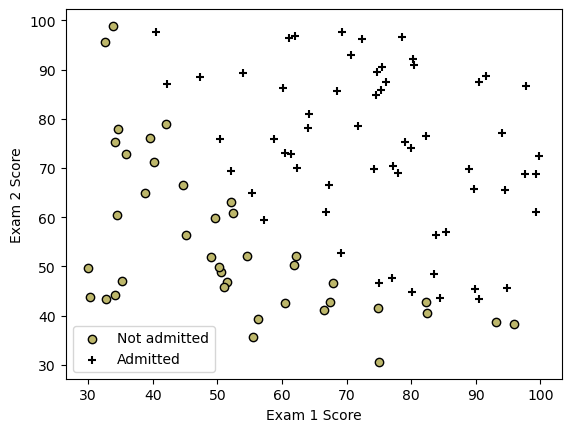

In [5]:
fig, ax = plt.subplots()

simple_scatter(X[KO][:, 0], X[KO][:, 1], figax=(fig, ax), marker="o", color="darkkhaki", edgecolor="black", legend="Not admitted")
simple_scatter(X[OK][:, 0], X[OK][:, 1], figax=(fig, ax), marker="+", color="black", xlab="Exam 1 Score", ylab="Exam 2 Score", legend="Admitted")

ax.legend()

## 1.2 Implémentation

Avant de commencer, rappelons que la regression logistique est définie par
$$
h(\Theta) = g(\Theta^{t}x) = \frac{1}{1 + e^{-\Theta^{t}x}}
$$
où $g$ est la sigmoid
$$
g(z) := \frac{1}{1 + e^{-z}}
$$

Nous allons maintenant implémenter ces fonctions, ce qui va être utile pour le reste du TP.

In [38]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

In [58]:
def h_fct(theta, x):
    return sigmoid(np.inner(theta, x))

In [40]:
# testing the sigmoid function
sigmoid(-100)

3.7200759760208356e-44

## 1.3 Loss function et gradient

Nous allons maintenant implémenter la loss fonction, rappelons que cette dernière est
$$
J(\Theta) = -\frac{1}{m} \left( \sum_{i=0}^{m}y_{i}\log(h(x_{i})) + (1 - y_{i})\log(1 - h(x_{i}))     \right)
$$
Et le gradient de cette fonction est un vecteur de même longueur que $\Theta$ avec
$$
\frac{\partial J(\Theta)}{\partial \theta_{0}} = \frac{1}{m} \sum_{i=1}^{m}(h(x_{i}) - y_{i})
$$
et pour $j>0$, on obtient.
$$
\frac{\partial J(\Theta)}{\partial \theta_{j}} = \frac{1}{m} \sum_{i=1}^{m}(h(x_{i}) - y_{i})(x_{i})_{j}
$$
Remarquez que le gradient ressemble beaucoup au gradient de la régression linéaire.

In [41]:
0.0 * np.inf

nan

In [55]:
def lossFunction (theta, x, y):
    m = len(x)
    ret = 0

    h = h_fct(theta, x)
    return (-1 / m) * np.sum(np.log(h) + (1.0 - y) * np.log(1.0 - h))
    #return (-1 / m) * np.sum(np.log(h_fct(theta, x)) + (1 - y) * np.log(1 - h_fct(theta, x)))

In [56]:
lossFunction(np.array([1.0, 1.0, 2.0]), newX, Y)

/tmp/ipykernel_6752/3311232510.py:6: RuntimeWarning: divide by zero encountered in log
  return (-1 / m) * np.sum(np.log(h) + (1.0 - y) * np.log(1.0 - h))
/tmp/ipykernel_6752/3311232510.py:6: RuntimeWarning: invalid value encountered in multiply
  return (-1 / m) * np.sum(np.log(h) + (1.0 - y) * np.log(1.0 - h))


nan

## 1.4 Optimisation des paramètres

Dans le TP précédent, nous avons trouvé les paramètres optimaux de la régression linéaire en utilisant notre propre implémentation de la descente du gradient. 


En pratique, il est plus commun d'utiliser des packages spécialement conçu pour ce genre de problème. Dans ce TP, nous allons utiliser $\texttt{scipy.optimize.minimize}$ pour déterminer $\Theta$. 
Si la fonction coût a été correctement implémentée $\texttt{scipy.optimize.minimize}$ va converger vers les paramètres optimaux $\Theta$.

In [48]:
# TODO: add a '1' to the first component of each data x
# Each data point (x_{1}, x_{2}) should become (1, x_{1}, x_{2})
# initial theta values
theta = (0, 0, 0)
newX = np.concatenate((np.ones((100, 1)), X), axis=1)

lossFunction(theta, newX, Y)
# apply optimization
# TODO: compute the optimal parameter

ret is  0
h_fct 0.5
y[i] 0.0
ret is  -0.6931471805599453
h_fct 0.5
y[i] 0.0
ret is  -1.3862943611198906
h_fct 0.5
y[i] 0.0
ret is  -2.0794415416798357
h_fct 0.5
y[i] 1.0
ret is  -2.772588722239781
h_fct 0.5
y[i] 1.0
ret is  -3.4657359027997265
h_fct 0.5
y[i] 0.0
ret is  -4.1588830833596715
h_fct 0.5
y[i] 1.0
ret is  -4.852030263919617
h_fct 0.5
y[i] 1.0
ret is  -5.545177444479562
h_fct 0.5
y[i] 1.0
ret is  -6.238324625039508
h_fct 0.5
y[i] 1.0
ret is  -6.931471805599453
h_fct 0.5
y[i] 0.0
ret is  -7.6246189861593985
h_fct 0.5
y[i] 0.0
ret is  -8.317766166719343
h_fct 0.5
y[i] 1.0
ret is  -9.010913347279288
h_fct 0.5
y[i] 1.0
ret is  -9.704060527839234
h_fct 0.5
y[i] 0.0
ret is  -10.39720770839918
h_fct 0.5
y[i] 1.0
ret is  -11.090354888959125
h_fct 0.5
y[i] 1.0
ret is  -11.78350206951907
h_fct 0.5
y[i] 0.0
ret is  -12.476649250079015
h_fct 0.5
y[i] 1.0
ret is  -13.16979643063896
h_fct 0.5
y[i] 1.0
ret is  -13.862943611198906
h_fct 0.5
y[i] 0.0
ret is  -14.556090791758852
h_fct 0.5
y[i]

0.693147180559946

On peut maintenant utiliser ce paramètres $\Theta$ pour tracer un seuil de jugement sur le training dataset.

In [13]:
# TODO: plot the data and the decision boundary

### 1.5 Evaluation de la régression logisitique

Maintenant que nous connaissons les paramètres optimaux de notre régression logistique, il est possible de l'utiliser afin de savoir pour décider si un étudiant doit être accepté ou pas. Pour un étudiant avec un score de $45$ à l'examen $1$ et $85$ à l'examen $2$. Nous devrions trouver un score d'environ $0.7763$.

In [14]:
# TODO compute the score of a student who has a score of 45 at the first test and 85 at the second.

## 2. Régularisation de la fonction logistique

###  2.1 Data visualisation

Pour cet exercice, nous allons utiliser un nouveau dataset. Ce dataset, que vous pouvez trouver dans $\texttt{ex2data2.txt}$, contient le score de puces éléctroniques à deux différents tests ainsi que si la puce a été jugée conforme à certains critères de qualité ou pas. Plus précisément, $y$ vaut un si la puce a été jugée conforme aux critères de qualités et $y=0$ sinon. Comme avant, commençons par visualiser notre dataset.

In [15]:
with open('ex2data2.txt') as f2:
    dataset_2 = np.loadtxt(f2, delimiter = ',',dtype = 'float', usecols = None)
    
X = dataset_2[:, :-1]
Y = dataset_2[:, 2]
KO = np.where(Y == 0)[0]
OK = np.where(Y)[0]

FileNotFoundError: [Errno 2] No such file or directory: 'ex2data2.txt'

In [ ]:
# TODO: plot the data

Remarquer qu'on ne peut pas ne pas séparer les $y=1$ et les $y=0$ par une fonction linéaire. Par conséquent, une application directe de la régression logistique fournira de mauvais résultats sur ce dataset.

### 2.2 Kernel trick

Une manière de contourner cette limitation est de plonger nos données initial dans un espace de plus grande dimension où il sera possible de séparer nos points linéairement. C'est ce que nous appelons le 'kernel trick' (astuce du noyau).

Pour faire cela, nous allons utiliser une fonction 'mapFeature' défini par
$$
(x_{1}, x_{2}) \mapsto \left(
\begin{array}{c}
1 \\
x_1 \\
x_2\\
x_1^2\\
x_1x_2\\
x_2^2\\
x_1^3\\
\vdots \\
x_1x_2^5\\
x_2^6
\end{array} 
\right)
$$
plus précisément l'image de $(x_{1}, x_{2})$ est composé des monômes de la forme $x_{1}^{i-j}x_{2}^{j}$ avec $i$ allant de $0$ à $6$ et $j$ allant de $0$ à $i$.

In [ ]:
def mapFeature(x1, x2):
    # TODO: implement this function

Cette fonction va nous permettre de plonger notre dataset de dimension $2$ dans un espace de dimension $28$. Ensuite, nous allons appliquer une régression logistique linéaire dans cette espace, ce qui nous permettra de construire un seuil de décisions qui semblera plus complexe lorsque nour le projeterons dans notre espace inital à deux dimensions. 

In [ ]:
map_X = mapFeature(X[:, 0], X[:, 1])

### 2.3 Loss function et gradient

Cette approche nous permet de construire des modèles plus performants. Mais cela est également plus susceptible de mener à de l'overffiting. Pour éviter cela, nous allons régulariser notre loss fonction. Plus précisément, la loss fonction devient
$$
J(\Theta) = -\frac{1}{m} \left( \sum_{i=0}^{m}y_{i}\log(h(x)_{i}) + (1 - y_{i})\log(1 - h(x)_{i}) \right)
 + \frac{\lambda}{2m} \sum_{j=1}^{n} \theta_{j}^{2}   
$$
Noter que la deuxième somme commence seulement à l'indice $1$. Ce qui implique que nous ne régularisons pas sur le terme $\theta_{0}$. En particulier, les dérivées partielles deviennent
$$
\frac{\partial J(\mathbf{\Theta})}{\partial\theta_0}=\frac{1}{m}\sum_{i=1}^{m}(h(x_i)-y_i)(x_i)_{0} 
$$
pour $j=0$ et pour $j > 1$, 
$$
\frac{\partial J(\mathbf{\Theta})}{\partial \theta_j}=\left[\frac{1}{m}\sum_{i=1}^{m}\left(h(\mathbf{x}_i)-y_i\right)(x_i)_j{+\frac{\lambda}{m}\theta_j}\right]
$$

In [ ]:
def lossFunctionReg (theta, x, y, lamb):
    # TODO: implement this function

### 2.5 Seuil de décision

Comme pour l'exercice 1, nous allons maintenant utiliser $\texttt{scipy.optimize.minimize}$ afin de déterminier les paramètres optimaux.

In [ ]:
theta = np.zeros(28)
lamb = 0.5
# TODO: compute the optimal parameters

Nous allons maintenant tracer le seuil de décision dans l'espace initial à deux dimensions. Pour faire cela, nous pouvons calculer les valeurs sur une grille (après l'avoir plongé dans l'espace à $28$ dimensions) et tracer les valeurs pour lesquelles les prédictions changent de $y=0$ à $y=1$.

In [ ]:
# TODO: plot the decision boundary using the optimal parameters

Répéter maintenant la procédure ci-dessus en changeant la valeur de $\lambda$. Que pouvez-vous observer?


## 3. Régression polynomiale

Dans cette exercice, nous allons construire une régression polynomiale et étudier l'erreur de notre modèle sur le training et le validation dataset en fonction du degré de notre polynôme.

### 3.1 Visualisation du dataset

Comme d'habitude, nous allons commencer par visualiser nos datasets. Plus précisément, nous avons à dispositions deux différents datasets. 
1. Un dataset d'entrainement appelé training dataset, que nous allons utiliser pour entraîner notre modèle, qu'on peut trouver dans le fichier $\texttt{ex3_training.txt}$.
2. Un dataset d'évaluation appelé validation dataset, que nous allons utiliser pour évaluer notre modèle et déterminer nos hyperparamètre (le degré du polynôme d'interpolation dans notre cas) et qu'on peut trouver dans le fichier $\texttt{ex3_validation.txt}$.



In [ ]:
with open('ex3_training.txt') as f2:
    train_data = np.loadtxt(f2, delimiter = ' ',dtype = 'float', usecols = None)

X_train = train_data[0]
Y_train = train_data[1]


with open('ex3_validation.txt') as f2:
    eval_data = np.loadtxt(f2, delimiter = ' ',dtype = 'float', usecols = None)
X_eval =eval_data[0]
Y_eval =eval_data[1]

Pour commencer, nous pouvons déjà faire un plot de ces deux datasets.

In [ ]:
# TODO: plot this data


La couleur des points n'est évidemment pas importante, mais veuillez s'il vous plaît être cohérent sur l'ensemble de cet exercice. Gardez la même couleur pour le jeu de données d'entraînement et le jeu de données de validation tout au long de l'exercice.

### 3.2 Régression polynomiale

Nous allons maintenant utiliser nos données d'entraînement pour faire une régression polynomiale

In [ ]:
def fit_data(degree, X_train, Y_train, show=False):
    """
    degree: degree of the polynome used for the interpolation
    X_train, Y_train:  training data
    show: if set to true, this function plot the graph of the interpolation
    """
    # TODO: implement this function
        

On peut ensuite construire notre fonction 'fit_data' pour déterminer notre regression polynomiale ainsi que faire le plot de cette régression.

In [ ]:
with open('ex3_training.txt') as f2:
    train_data = np.loadtxt(f2, delimiter = ' ',dtype = 'float', usecols = None)

X_train = train_data[0]
Y_train = train_data[1]

_, _ = fit_data(3, X_train, Y_train, True)

### 3.3 Evaluation de notre modèle

Nous allons maintenant construire une fonction qui nous permettra d'évaluer notre modèle.

In [ ]:
def evaluate_model(parameters, X_eval, Y_eval, show=False):
    """
    Given the parameters of our model (which is expected to be a polynome), 
    we compute and return the MSE errors of its predictions on X_eval. 
    If show is set to true, we plot a graph of these predictions
    """
    # TODO: implement this function

En utilisant, ces deux dernières fonctions, on peut alors calculer les paramètres optimaux de notre d'une régression de degré 2 et tracer notre régression sur le training et la validation dataset.

In [ ]:
with open('ex3_training.txt') as f2:
    train_data = np.loadtxt(f2, delimiter = ' ',dtype = 'float', usecols = None)

X_train = train_data[0]
Y_train = train_data[1]

parameters, _ = fit_data(2, X_train, Y_train, True)

with open('ex3_validation.txt') as f2:
    eval_data = np.loadtxt(f2, delimiter = ' ',dtype = 'float', usecols = None)
X_eval =eval_data[0]
Y_eval =eval_data[1]

_ = evaluate_model(parameters, X_eval, Y_eval, show=True)

### 3.4 Under vs Overfitting

Nous allons maintenant utiliser les deux fonctions construites en $3.2$ et $3.3$ pour évaluer nos modèles en fonction du degré du polynôme d'interpolation. Pour commencer, nous allons déjà implémenter une fonction qui va construire le polynôme d'interpolation et calculer son erreur sur le training et le validation dataset pour des degrés variant entre deg_min et deg_max. Cette fonction, va retourner ces erreurs sous forme de deux vecteurs de dimensions (deg_max - deg_min).

In [ ]:
def compute_error(deg_min, deg_max, X_train, Y_train, X_val, Y_val):
    """
    This function build the polynomial interpolation, using (X_train and Y_train) datasets and evaluate it on (X_val, Y_val)
    and compute the train and validation errors.
    It builds a such interpolation for all degree between deg_min and deg_max. All training and validation errors are stored and 
    returned.
    """
    # TODO: implement this function
        

En utilisant cette fonction, on peut alors tracer la validation et training erreur en fonction du degré du polynôme d'interpolation.

In [ ]:
with open('ex3_training.txt') as f2:
    train_data = np.loadtxt(f2, delimiter = ' ',dtype = 'float', usecols = None)

X_train = train_data[0]
Y_train = train_data[1]
min_degree = 0
max_degree = 9

# TODO: plot the validation and train error according to the degree of our poylnomial regression

Comme on peut le voir ci-dessus, lorsque notre modèle est de degré petit, l'erreur sur le training et le validation dataset est grand. Dans ce cas, nous sommes en présence d'underfitting. Notre modèle n'est pas assez complexe pour s'adapter à la complexité des données avec lesquelles nous travaillons.


Lorsque notre polynôme est degré grand, l'erreur sur notre training dataset est très petite mais celle sur le validation dataset explose. Nous sommes en présence d'overfitting. Notre modèle est trop complexe pour nos données. Il apprend des caractéristiques non-pertinentes des données comme du bruit.